In [1]:
import numpy as np
import re
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Dense, LSTM, Input, Dropout, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow import keras

In [2]:
# детерминация случайных величин, отвечающих за выбор первоначальных весов и биасов
tf.compat.v1.set_random_seed(290)
tf.random.set_seed(290)
np.random.seed(400)

In [3]:
#///////////////////////////////// для колбэков

    # для Early_stopping
ES_patience = 20 # кол-во эпох без улучшений
ES_min_delta = 0.001 # минимальное улучшение параметра за cur_patience
ES_monitor_parametr =  'loss' # отслеживаемый параметр 
ES_save_best_weights = True # сохранять ли веса нейронки с лучшими результатами
    
    # для ReduceLROnPlateau
RLPOP_monitor_parametr = 'val_loss'  # отслеживаемый параметр 
RLPOP_factor = 0.1 # множитель для расчета нового шага сходимости (new_learning_rate = old_learning_rate*RLPOP_factor)
RLPOP_patience = 10 # кол-во эпох без улучшений
RLPOP_verbose = 1 # выводить ли прогресс изменения шага сходимости в его процессее
RLPOP_mode = 'auto' # выбирает, уменьшать шаг сходимости при росте величины или при её уменьшении
RLPOP_min_delta = 0.0001 # порог изменения отслеживаемого значения
RLPOP_cooldown = 0 # количество эпох до возобновления работы после изменения шага сходимости
RLPOP_min_lr = 0 # минимальное значение шага сходимости

    # для CallbackList
CBL_add_history = True # вызывать ли колбэк History (если он не был довавлен вручную)
CBL_add_progbar = True # вызывать ли колбэк ProgbarLogger (если он не был довавлен вручную)
    

In [4]:
def sequence_to_text(list_of_indices):
    words = [reverse_word_map.get(letter) for letter in list_of_indices]
    return(words)

In [5]:
# разделить данные на тренировочные и тестовые
def split(X,Y,factor):
    X_train=X[:factor]
    Y_train=Y[:factor]
    X_test=X[factor:]
    Y_test=Y[factor:]
    return X_train,Y_train,X_test,Y_test

In [6]:
with open('train_data_true', 'r', encoding='utf-8') as f:
    texts_true = f.readlines()
    texts_true[0] = texts_true[0].replace('\ufeff', '') #убираем первый невидимый символ

with open('train_data_false', 'r', encoding='utf-8') as f:
    texts_false = f.readlines()
    texts_false[0] = texts_false[0].replace('\ufeff', '') #убираем первый невидимый символ

In [7]:
texts = texts_true + texts_false
count_true = len(texts_true)
count_false = len(texts_false)
total_lines = count_true + count_false
print(count_true, count_false, total_lines)

84 88 172


In [8]:
maxWordsCount = 1000
tokenizer = Tokenizer(num_words=maxWordsCount, 
                      filters='!–"—#$%&amp;()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r«»', 
                      lower=True, 
                      split=' ', 
                      char_level=False)

tokenizer.fit_on_texts(texts)

reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))
print(reverse_word_map)

{1: 'не', 2: 'и', 3: 'в', 4: 'вы', 5: 'на', 6: 'я', 7: 'а', 8: 'только', 9: 'что', 10: 'все', 11: 'это', 12: 'если', 13: 'жизнь', 14: 'просто', 15: 'с', 16: 'чем', 17: 'никогда', 18: 'чтобы', 19: 'к', 20: 'у', 21: 'больше', 22: 'себя', 23: 'то', 24: 'всегда', 25: 'вас', 26: 'меня', 27: 'за', 28: 'вам', 29: 'когда', 30: 'от', 31: 'мне', 32: 'быть', 33: 'жизни', 34: 'есть', 35: 'но', 36: 'сделать', 37: 'без', 38: 'позитивным', 39: 'никому', 40: 'как', 41: 'ты', 42: 'тем', 43: 'для', 44: 'день', 45: 'позитивное', 46: 'своих', 47: 'мы', 48: 'много', 49: 'тебя', 50: 'никто', 51: 'такой', 52: 'деньги', 53: 'денег', 54: 'позитивно', 55: 'свою', 56: 'которые', 57: 'значит', 58: 'так', 59: 'них', 60: 'мечты', 61: 'нужно', 62: 'того', 63: 'ничего', 64: 'лучше', 65: 'надо', 66: 'верьте', 67: 'понедельник', 68: 'живи', 69: 'позволяйте', 70: 'хорошее', 71: 'можете', 72: 'ваши', 73: 'других', 74: 'делай', 75: 'тебе', 76: 'можешь', 77: 'успеха', 78: 'ваша', 79: 'стоит', 80: 'себе', 81: 'своей', 82: '

In [9]:
dist = list(tokenizer.word_counts.items())
print(dist[:10])
print(texts[0][:100])

[('думайте', 1), ('позитивно', 4), ('и', 50), ('верьте', 3), ('в', 38), ('свою', 4), ('способность', 1), ('достигать', 1), ('отличных', 1), ('результатов', 1)]
Думайте позитивно и верьте в свою способность достигать отличных результатов. 



In [10]:
max_text_len = 10
data = tokenizer.texts_to_sequences(texts)
data_pad = pad_sequences(data, maxlen = max_text_len)
print(data_pad)

#print( list(tokenizer.word_index.items()) )

[[197  54   2 ... 199 200 201]
 [  0   4 202 ... 205   3  67]
 [206   3  67 ...   4 208 209]
 ...
 [  0  20  62 ...  53 850 851]
 [  0   0  43 ...  33   1 853]
 [  0   0   0 ...  70  65 194]]


In [11]:
X_data = data_pad
#Y_data = np.array([[1, 0]]*count_true + [[0, 1]]*count_false)
Y_data = np.array([1]*count_true + [0]*count_false)
print(X_data.shape, Y_data.shape)

#indeces = np.random.choice(X_data.shape[0], size = X_data.shape[0], replace=False)
indeces = np.random.choice(X_data.shape[0], size = X_data.shape[0], replace=False)
#print(indeces)
X_data = X_data[indeces]
Y_data = Y_data[indeces]

factor = int(.80 * X_data.shape[0])

#X_test = X_data[round(len(X_data) * 0,9):]
#Y_test = Y_data[round(len(Y_data) * 0,9):]

#X_train = X_data[:round(len(X_data) * 0,9)]
#Y_train = Y_data[:round(len(Y_data) * 0,9)]

X_train,Y_train,X_test,Y_test = split(X_data,Y_data,factor)

#print(data_pad.shape)
#print("indeces: ", indeces)
print("train: ", X_train.shape, Y_train.shape)
print("test: ", X_test.shape, Y_test.shape)

#for x in range(100):
#    print(sequence_to_text(X_train[x]), f"\t[{Y_train[x]}]")

(172, 10) (172,)
train:  (137, 10) (137,)
test:  (35, 10) (35,)


In [12]:
#print(X.shape)
#LSTM?
#Sequential.compile?

In [13]:
model = Sequential()
model.add(Embedding(maxWordsCount, 128, input_length = max_text_len))
model.add(LSTM(128, return_sequences=True, dropout = 0.3))
model.add(LSTM(64, dropout = 0.3))
#model.add(Dense(2, activation='softmax'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 128)           128000    
_________________________________________________________________
lstm (LSTM)                  (None, 10, 128)           131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 309,057
Trainable params: 309,057
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Создание и настройка колбэков
callback_list = [] # массив колбэков до подачи в колбек "callbacklist"

temp = keras.callbacks.EarlyStopping(
            monitor = ES_monitor_parametr, 
            min_delta = ES_min_delta, 
            patience = ES_patience,
            restore_best_weights = ES_save_best_weights
            )
callback_list.append(temp)

temp = keras.callbacks.ReduceLROnPlateau(
            monitor = RLPOP_monitor_parametr, 
            factor = RLPOP_factor, 
            patience = RLPOP_patience, 
            verbose = RLPOP_verbose,
            mode = RLPOP_mode, 
            min_delta = RLPOP_min_delta, 
            cooldown = RLPOP_cooldown, 
            min_lr = RLPOP_min_lr
            )
callback_list.append(temp)

FIT_callback_list = keras.callbacks.CallbackList(
            callbacks = callback_list, 
            add_history = CBL_add_history, 
            add_progbar = CBL_add_progbar, 
            model = model
            )

In [15]:
model.compile(loss='mean_squared_error', 
              metrics=['accuracy'], 
              optimizer = tf.keras.optimizers.SGD(learning_rate=0.1)) #Adam(0.0003)) #'categorical_crossentropy'

In [16]:
FIT_batch_size = 15
history = model.fit(X_train, 
                    Y_train, 
                    batch_size = FIT_batch_size, 
                    shuffle = True, 
                    verbose = 1, 
                    epochs = 70, #30, 
                    validation_split = 0.20,
                    callbacks = FIT_callback_list)

8/8 [==============================] - 0s 5ms/step - loss: 0.1453 - accuracy: 0.8073 - val_loss: 0.1390 - val_accuracy: 0.7500


8/8 [==============================] - 0s 5ms/step - loss: 0.1192 - accuracy: 0.8624 - val_loss: 0.1359 - val_accuracy: 0.7500


In [17]:
#Sequential.fit?

In [18]:
#reverse_word_map = dict(map(reversed, tokenizer.word_index.items()))

In [19]:
#t = "негативы".lower()
#data = tokenizer.texts_to_sequences([t])
#print(data)
#data_pad = pad_sequences(data, maxlen=max_text_len)
#print( sequence_to_text(data[0]) )

for x in range(len(X_test)): 
    res = model.predict(X_test[x])
        #print(' '.join(sequence_to_text(x)))
    mark = "Положительно" if np.argmax(res) == 1 else "отрицательно"
    mark2 = "Положительно" if Y_test[x] == 1 else "отрицательно"
    equal = "==" if mark == mark2 else "  "
    print(f"Maybe[{mark}] " + equal + f" Right[{mark2}]\t" +  ' '.join(list(filter(None, sequence_to_text(X_test[x])))) )
        #print("res: ", res )
        #print("Положительно" if np.argmax(res) == 1 else "отрицательно")
    

Maybe[отрицательно]    Right[Положительно]	и способности вам не нужно всегда идти по стопам других
Maybe[отрицательно] == Right[отрицательно]	говорила я тебе не верь никому
Maybe[отрицательно]    Right[Положительно]	либо ты бежишь день либо день бежит за тобой
Maybe[отрицательно] == Right[отрицательно]	помогай это к добру не приведет все равно виноватым будешь
Maybe[отрицательно]    Right[Положительно]	не позволяйте утренним проблемам помешать вам быть успешным
Maybe[отрицательно] == Right[отрицательно]	у меня такая плохая карма
Maybe[отрицательно] == Right[отрицательно]	ни один врач не сможет вылечить мою болезнь
Maybe[отрицательно] == Right[отрицательно]	к врачам только попади сразу найдут кучу болезней
Maybe[отрицательно] == Right[отрицательно]	здоровое питание сильно дорого для меня
Maybe[отрицательно]    Right[Положительно]	мы все можем привнести позитивную энергию в нашу повседневную жизнь
Maybe[отрицательно] == Right[отрицательно]	стоит только пожениться тут же начинаются ссора 

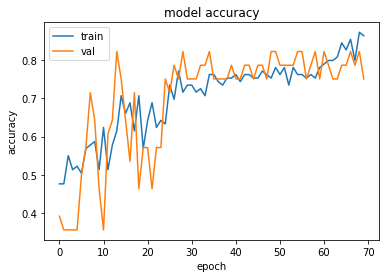

In [20]:
# Вывод графика изменения ошибки
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [21]:
# тест модели
model.evaluate(X_test, Y_test, batch_size = FIT_batch_size)

3/3 [==============================] - 0s 1ms/step - loss: 0.1503 - accuracy: 0.8286


[0.15032997727394104, 0.8285714387893677]

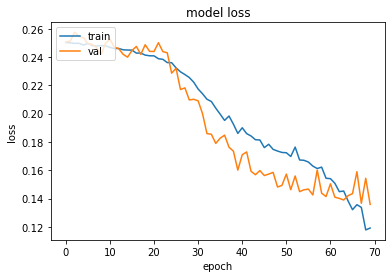

In [22]:
# Вывод графика изменения ошибки
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc = 'upper left')
plt.show()

In [31]:
t = "если вы просто посмотрите на жизнь позитивно произойдут позитивные вещи".lower()
data = tokenizer.texts_to_sequences([t])
print(data)
data_pad = pad_sequences(data, maxlen = max_text_len)
print( sequence_to_text(data[0]) )

res = model.predict(data_pad)

mark = "Положительно" if round(res[0,0]) == 1 else "отрицательно"
print(f"[{mark}]")

print(res[0,0])

[[12, 4, 14, 351, 5, 13, 54, 352, 144, 128]]
['если', 'вы', 'просто', 'посмотрите', 'на', 'жизнь', 'позитивно', 'произойдут', 'позитивные', 'вещи']
[Положительно]
0.925172
